In [1]:
# Packages -----------------------------------------------#

# Data Analysis
import xarray as xr
import numpy as np
import pandas as pd
from scipy import stats
from scipy.ndimage import gaussian_filter
import datetime as dt
from scipy.interpolate import griddata

# Plotting
import cartopy.crs as ccrs
from cartopy.feature import LAND
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib as mpl
import cmocean

# Timing Processes and Progress
import time
from tqdm import tqdm
import itertools

# make sure the figures plot inline rather than at the end
%matplotlib inline

In [2]:
def add_land(ax,bounds= [45,100,0,30]):
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    ax.add_feature(cfeature.LAND,color='gray',zorder = 1)
    ax.background_patch.set_facecolor('k')
    ax.coastlines(resolution='110m',zorder = 2)
    g = ax.gridlines(draw_labels=True,alpha=0)
    g.xlabels_top = False
    g.ylabels_right = False
    g.xlabel_style = {'size': 15}
    g.ylabel_style = {'size': 15}
    g.xformatter = LONGITUDE_FORMATTER
    g.yformatter = LATITUDE_FORMATTER
    ax.axes.axis('tight')
    ax.set_extent(bounds, crs=ccrs.PlateCarree())
    return None 

def gaus_filter_nan(img,sigma = 1):
    # import required packages
    from astropy.convolution import convolve
    from astropy.convolution import Gaussian2DKernel
    
    # create a kernal with std = 1
    kernel = Gaussian2DKernel(x_stddev=1)
    
    #convolve that with the 2d matrix
    img_conv = convolve(img, kernel)

    # set original nan points back to nans
    img_conv[np.isnan(img)] = np.nan

    return img_conv

# mask coastlines ---------------------------------------------------------------------#
def mask_coast(c_lon,c_lat,bounds):
    data=xr.open_dataset('/tigress/GEOCLIM/LRGROUP/shared_data/pco2_flux_coastal_Roobaert/mask_ocean.nc')
    mask_coast=np.array(data.mask_coastal2).astype(int).T
    lat=np.array(data.latitude)
    lon=np.array(data.longitude)

    mask_lon=np.logical_and(lon>bounds[0],lon<bounds[1])
    mask_lat=np.logical_and(lat>bounds[2],lat<bounds[3])

    lon=lon[mask_lon]
    lat=lat[mask_lat]

    mask_coast=mask_coast[mask_lat]
    mask_coast=mask_coast[:,mask_lon]

    lonlon,latlat=np.meshgrid(lon,lat)

    # what are these for? I should probably fix it
    lon_dot=np.array([70,70])
    lat_dot=np.array([10,19.5])

    mask=[]
    for lo,la in zip(c_lon,c_lat):
        if len(lon[lon<=lo])>0 and len(lat[lat>=la])>0 and len(lon[lon>=lo])>0 and len(lat[lat<=la])>0:
            lon_lim=[lon[lon<=lo][-1],lon[lon>=lo][0]]
            lat_lim=[lat[lat<=la][-1],lat[lat>=la][0]]
            mask_lon=np.logical_or(lon==lon_lim[0],lon==lon_lim[1])
            mask_lat=np.logical_or(lat==lat_lim[0],lat==lat_lim[1])
            mask_tmp=mask_coast[mask_lat]
            mask_tmp=mask_tmp[:,mask_lon]
            mask.append(np.mean(mask_tmp)>0)
        else:
            mask.append(False)
    mask=np.array(mask)
    return mask



In [3]:
# WOA Raw
path_WOA = '../data/WOA/'
infn_WOA = 'woa_processed.nc'

ds_WOA = xr.open_dataset(path_WOA + infn_WOA)

# WOA CP
path_CD = '../data/CD/'
infn_CD = 'cd_woa.nc'

ds_CD= xr.open_dataset(path_CD + infn_CD)
# ds_CD

In [4]:
# WOA CP
path_CD = '../data/CD/'
infn_CD = 'cd_woa.nc'

ds_CD= xr.open_dataset(path_CD + infn_CD)
# ds_CD

In [5]:
xx,yy = np.meshgrid(np.array(ds_WOA.lon),np.array(ds_WOA.lat))

mask = mask_coast(xx.flatten(),yy.flatten(),[35,120,-20,30])
mask.shape

(5700,)

In [6]:
var = ds_CD.doxy_TCP_200_mean

#######################################################
#______________________________________________________
# annual mean
#______________________________________________________
ann_mean = np.nanmean(var,0) # 0 = time

# get seasonal anomaly
# 0 = MAM, 1 = JJA, 2 = SON, 3 = DJF
seasonal_anom = np.full([4,len(ds_CD.lat),len(ds_CD.lon)],np.nan)
seasonal_mean = np.full([4,len(ds_CD.lat),len(ds_CD.lon)],np.nan)
seasonal_OCP = np.full([4,len(ds_CD.lat),len(ds_CD.lon)],np.nan)
seasonal_TCP = np.full([4,len(ds_CD.lat),len(ds_CD.lon)],np.nan)
seasonal_TCP_20 = np.full([4,len(ds_CD.lat),len(ds_CD.lon)],np.nan)
for ss in range(4):
    if ss == 0:
        ind = [2,3,4] # MAM - -1 for index
        seasonal_mean[ss,:,:] = np.nanmean(var[ind,:,:],0)
        seasonal_anom[ss,:,:] = np.nanmean(var[ind,:,:],0) - ann_mean
        seasonal_OCP[ss,:,:] = np.nanmean(ds_CD.OCP[ind,:,:],0)
        seasonal_TCP[ss,:,:] = np.nanmean(ds_CD.TCP[ind,:,:],0)
        seasonal_TCP_20[ss,:,:] = np.nanmean(ds_CD.TCP_thresh_20[ind,:,:],0)
        
    elif ss == 1:
        ind = [5,6,7] # JJA
        seasonal_mean[ss,:,:] = np.nanmean(var[ind,:,:],0)
        seasonal_anom[ss,:,:] = np.nanmean(var[ind,:,:],0) - ann_mean
        seasonal_OCP[ss,:,:] = np.nanmean(ds_CD.OCP[ind,:,:],0)
        seasonal_TCP[ss,:,:] = np.nanmean(ds_CD.TCP[ind,:,:],0)
        seasonal_TCP_20[ss,:,:] = np.nanmean(ds_CD.TCP_thresh_20[ind,:,:],0)
        
    elif ss == 2:
        ind = [8,9,10] # SON
        seasonal_mean[ss,:,:] = np.nanmean(var[ind,:,:],0)
        seasonal_anom[ss,:,:] = np.nanmean(var[ind,:,:],0) - ann_mean
        seasonal_OCP[ss,:,:] = np.nanmean(ds_CD.OCP[ind,:,:],0)
        seasonal_TCP[ss,:,:] = np.nanmean(ds_CD.TCP[ind,:,:],0)
        seasonal_TCP_20[ss,:,:] = np.nanmean(ds_CD.TCP_thresh_20[ind,:,:],0)
    elif ss == 3:
        ind = [11,0,1] # DJF
        seasonal_mean[ss,:,:] = np.nanmean(var[ind,:,:],0)
        seasonal_anom[ss,:,:] = np.nanmean(var[ind,:,:],0) - ann_mean
        seasonal_OCP[ss,:,:] = np.nanmean(ds_CD.OCP[ind,:,:],0)
        seasonal_TCP[ss,:,:] = np.nanmean(ds_CD.TCP[ind,:,:],0)
        seasonal_TCP_20[ss,:,:] = np.nanmean(ds_CD.TCP_thresh_20[ind,:,:],0)

#______________________________________________________
# month of lowest oxygen, value of lowest oxygen in shelf waters
#______________________________________________________
mons = np.arange(1,13)

min_mean = np.full([len(ds_CD.lat),len(ds_CD.lon)],np.nan)
min_mean_mon = np.full([len(ds_CD.lat),len(ds_CD.lon)],np.nan)
min_mean_seas = np.full([len(ds_CD.lat),len(ds_CD.lon)],np.nan)

for ii,jj in itertools.product(np.arange(len(ds_CD.lat)),np.arange(len(ds_CD.lon))):
    doxy = var[:,ii,jj]
    
    if np.sum(doxy[np.isfinite(doxy)])>0:
        ind = np.nanargmin(doxy)

        min_mean[ii,jj] = doxy[ind]
        min_mean_mon[ii,jj] = mons[ind]
        
        if (mons[ind] >2) & (mons[ind] <6):
            min_mean_seas[ii,jj] = 1
        elif (mons[ind] >5) & (mons[ind] <9):
            min_mean_seas[ii,jj] = 2
        elif (mons[ind] >8) & (mons[ind] <12):
            min_mean_seas[ii,jj] = 3
        else:
            min_mean_seas[ii,jj] = 4



/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: Runtime

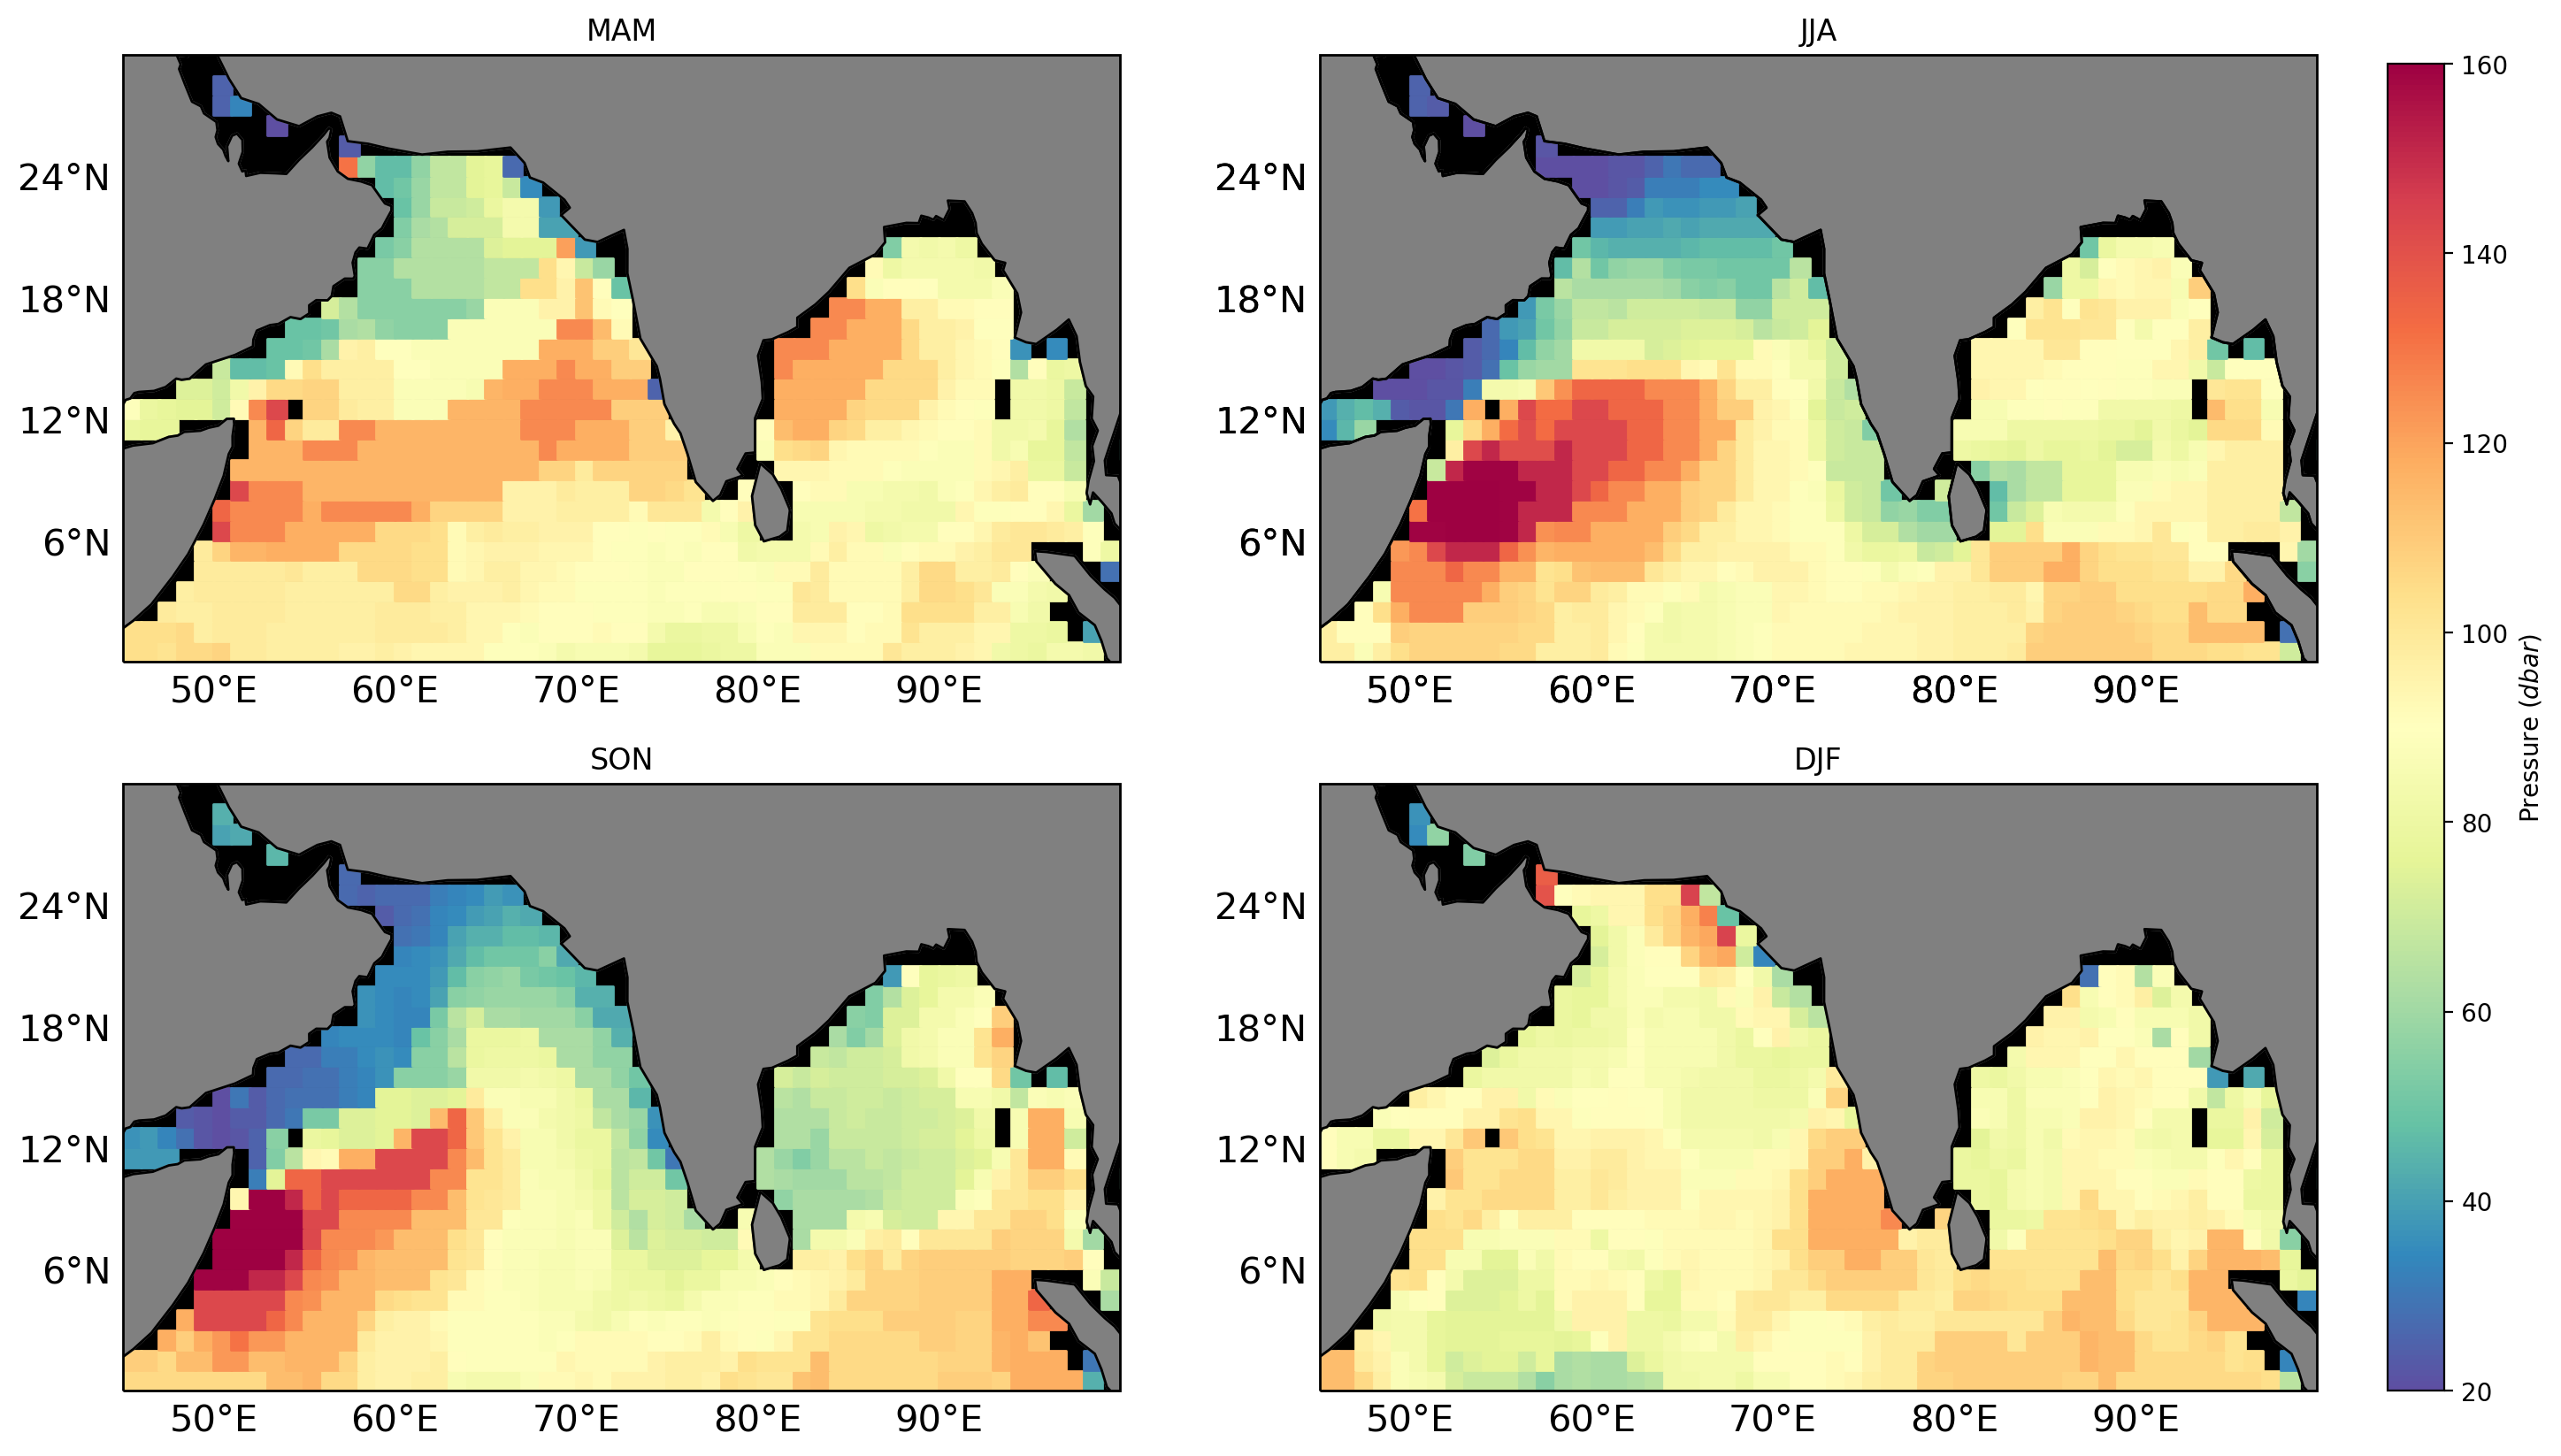

In [7]:
var = seasonal_TCP

season_title = ['MAM','JJA','SON','DJF']

fig, axes = plt.subplots(nrows = 2, ncols = 2,figsize=(16,10),dpi=200,subplot_kw={'projection': ccrs.PlateCarree()})
sz = 60
cmin = 20
cmax = 160
cmap = plt.cm.Spectral_r
xx,yy = np.meshgrid(ds_CD.lon,ds_CD.lat)
xx = xx.flatten()
yy = yy.flatten()


ax = axes[0,0]
tmp = var[0,:,:]
p = ax.scatter(xx,yy,c = tmp.flatten(),marker='s',s= sz,
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
ax.set_title(season_title[0])
add_land(ax)

ax = axes[0,1]
add_land(ax)
tmp = var[1,:,:]
p = ax.scatter(xx,yy,c = tmp.flatten(),marker='s',s= sz,
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
add_land(ax)
ax.set_title(season_title[1])

ax = axes[1,0]
tmp = var[2,:,:]
p = ax.scatter(xx,yy,c = tmp.flatten(),marker='s', s= sz,
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
add_land(ax)
ax.set_title(season_title[2])

ax = axes[1,1]
tmp = var[3,:,:]
p = ax.scatter(xx,yy,c = tmp.flatten(),marker='s',s= sz,
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
add_land(ax)
ax.set_title(season_title[3])


cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(p,cax=cbar_ax, pad=0.04)
cbar.set_label('Pressure ($dbar$)')


/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


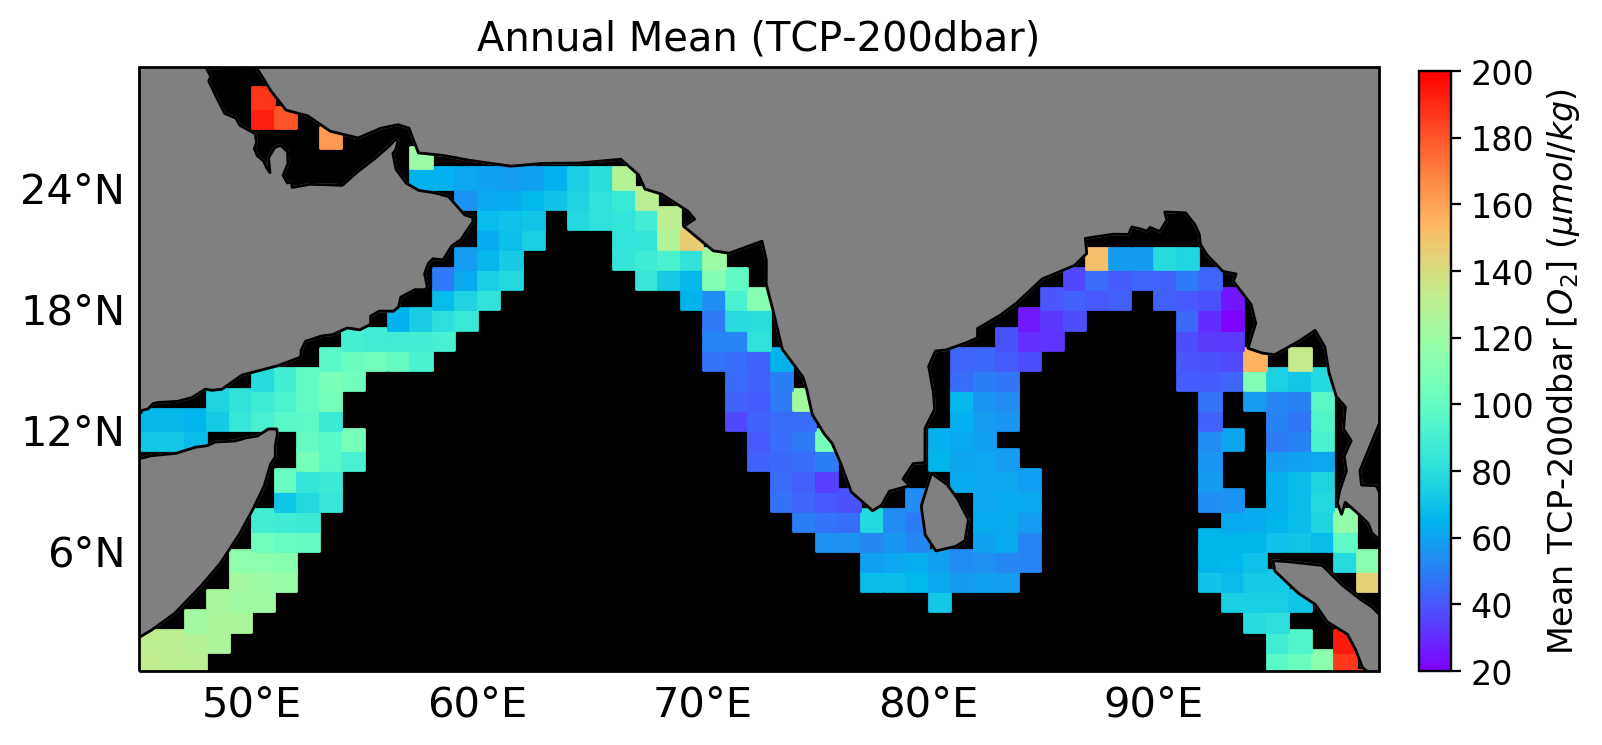

In [8]:
var = ann_mean

coastal = True

fig, ax = plt.subplots(nrows = 1, ncols = 1,figsize=(8,4),dpi=200,subplot_kw={'projection': ccrs.PlateCarree()})
sz = 60
cmin = 20
cmax = 200
cmap = plt.cm.rainbow
plt.rcParams.update({'font.size': 12})

##############################################################
title = 'Annual Mean (TCP-200dbar)'
xx,yy = np.meshgrid(ds_CD.lon,ds_CD.lat)
xx = xx.flatten()
yy = yy.flatten()

if coastal == True:
    tmp = var.flatten()
    p = ax.scatter(xx[mask],yy[mask],c = tmp[mask],marker='s',s= sz,
                          cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
    ax.set_title(title)
    add_land(ax)

    cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
    cbar = fig.colorbar(p,cax=cbar_ax, pad=0.04)
    cbar.set_label('Oxygen ($\mu mol/ kg$)')
else:
    tmp = var.flatten()
    p = ax.scatter(xx,yy,c = tmp,marker='s',s= sz,
                          cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
    ax.set_title(title)
    add_land(ax)

cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(p,cax=cbar_ax, pad=0.04)
cbar.set_label('Mean TCP-200dbar [$O_2$] ($\mu mol/ kg$)')





Text(0.5, 0.95, 'Seasonal Mean')

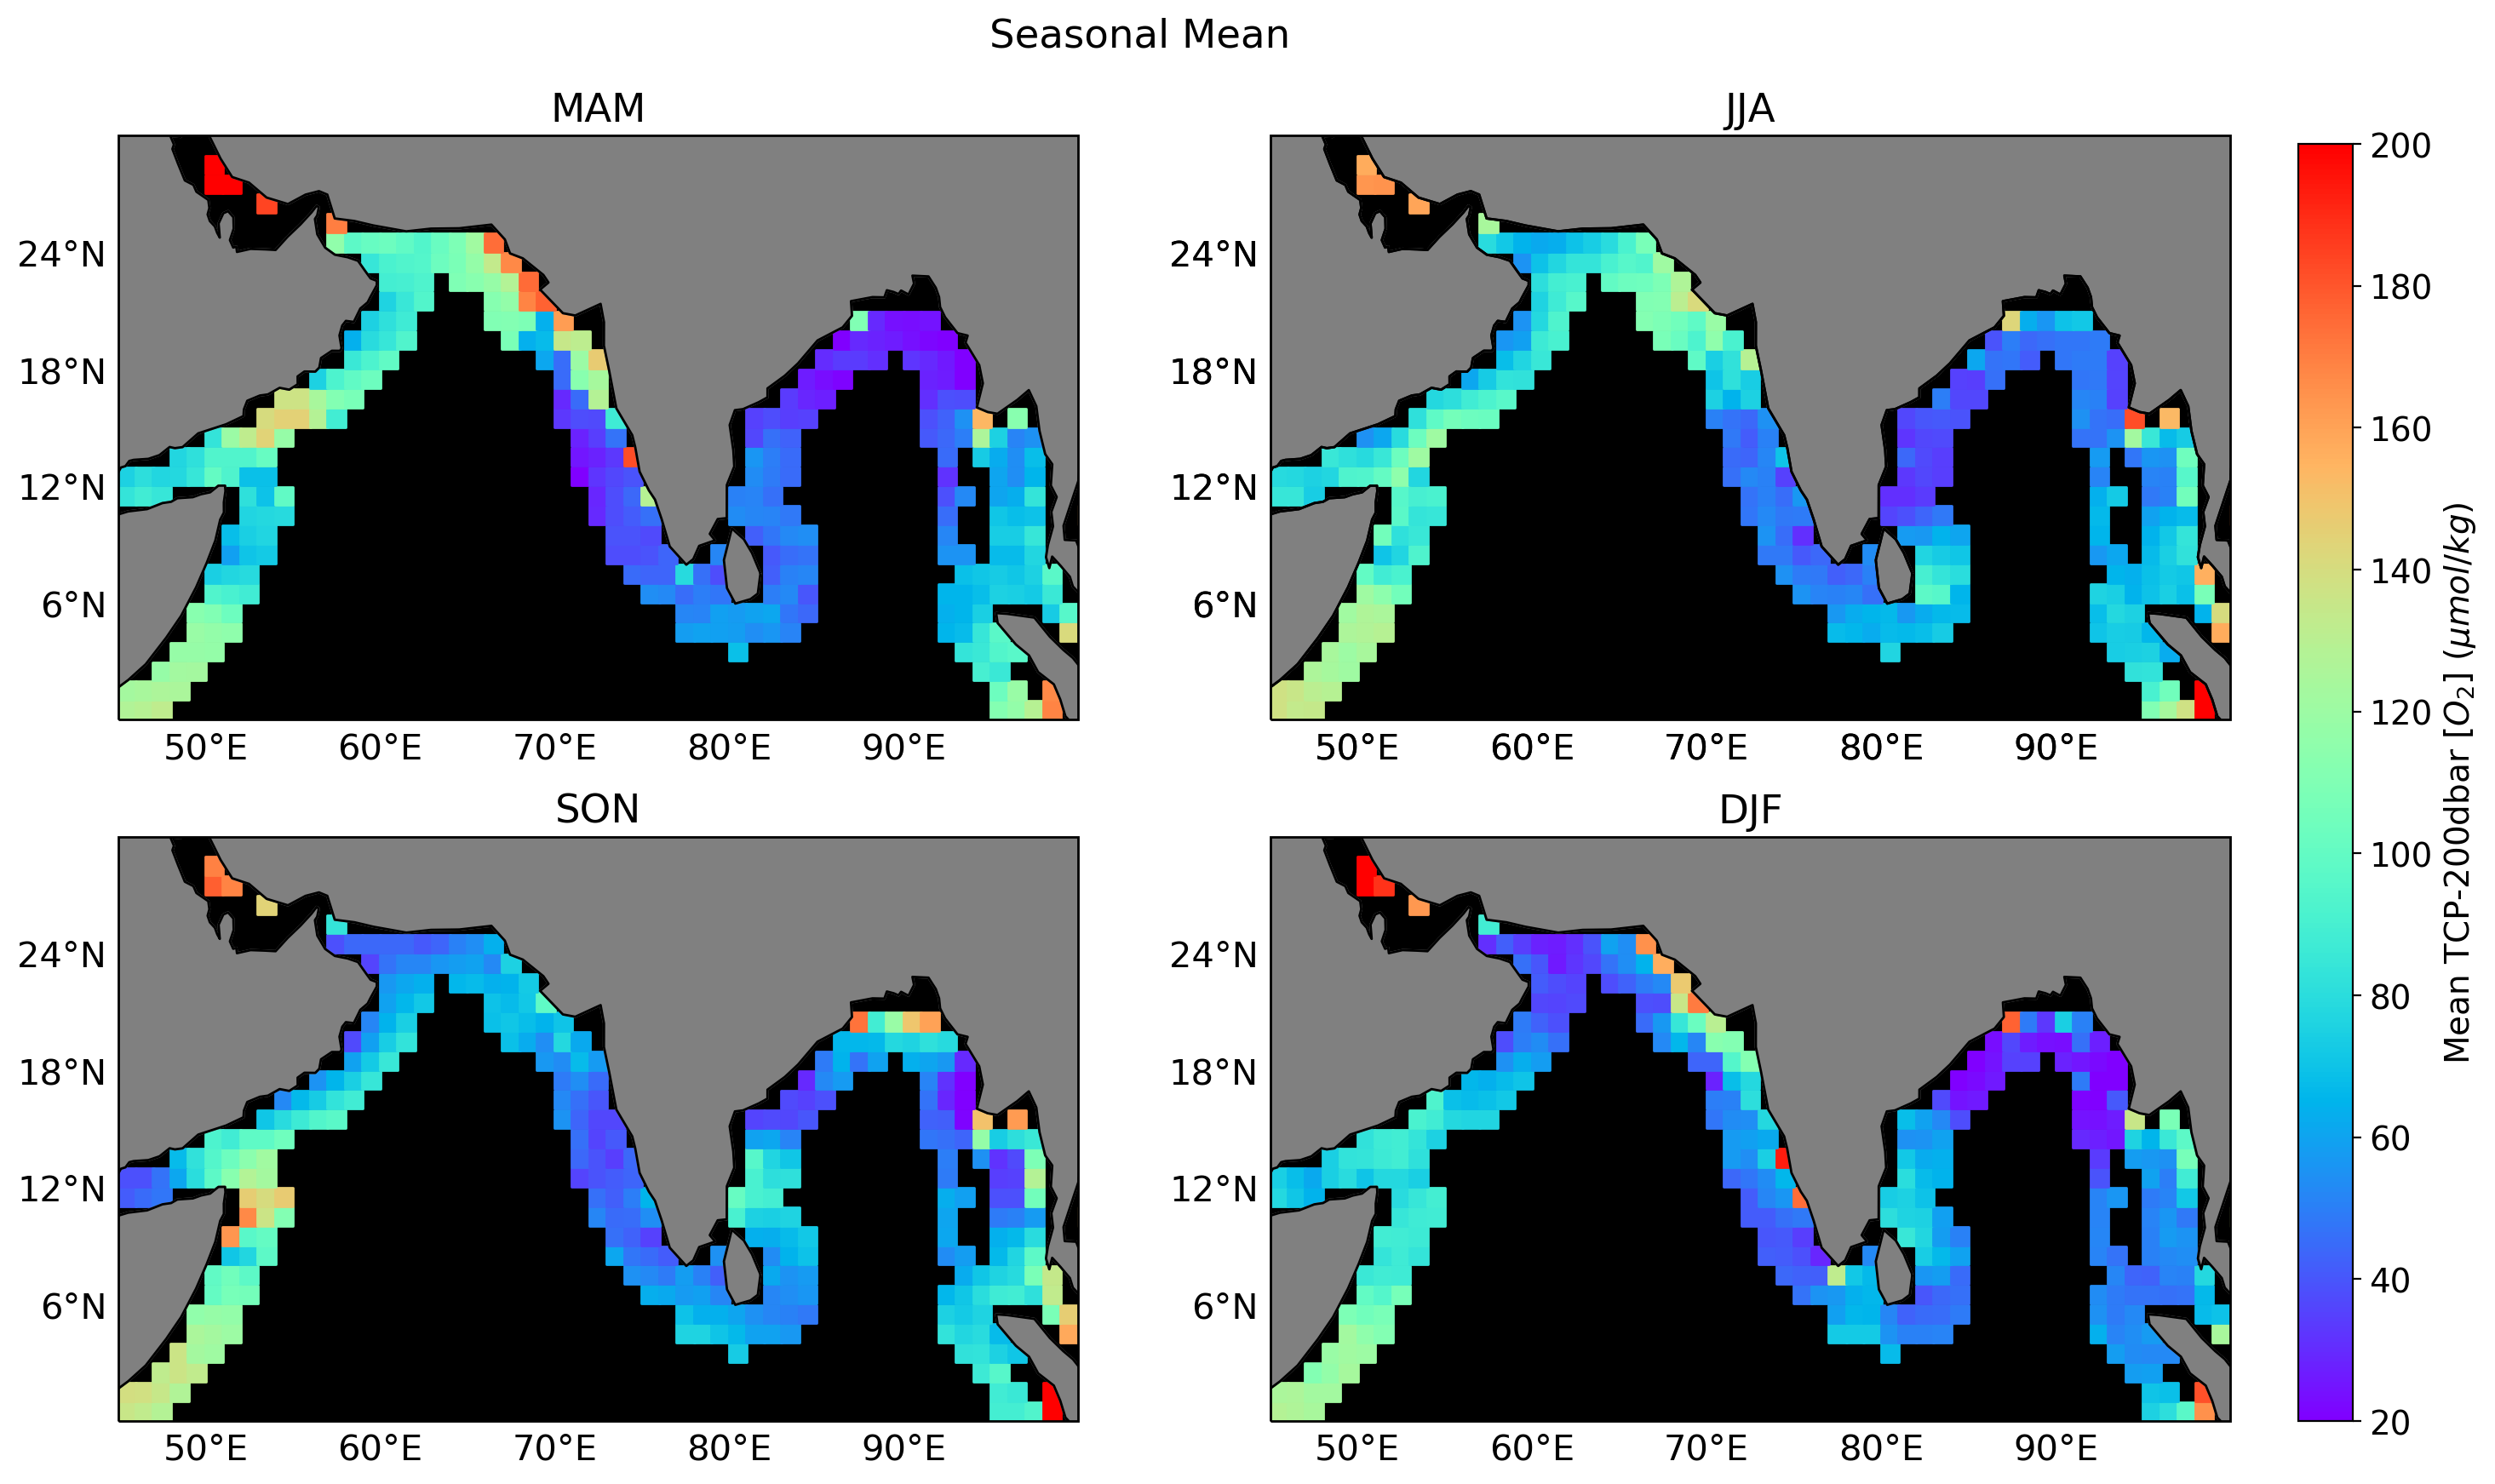

In [9]:
var = seasonal_mean

coastal = True

fig, axes = plt.subplots(nrows = 2, ncols = 2,figsize=(16,10),dpi=200,subplot_kw={'projection': ccrs.PlateCarree()})
sz = 60
cmin = 20
cmax = 200
cmap = plt.cm.rainbow
plt.rcParams.update({'font.size': 14})

##############################################################
season_title = ['MAM','JJA','SON','DJF']
xx,yy = np.meshgrid(ds_CD.lon,ds_CD.lat)
xx = xx.flatten()
yy = yy.flatten()

if coastal == True:
    ax = axes[0,0]
    tmp = var[0,:,:]
    tmp = tmp.flatten()
    p = ax.scatter(xx[mask],yy[mask],c = tmp[mask],marker='s',s= sz,
                          cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
    ax.set_title(season_title[0])
    add_land(ax)

    ax = axes[0,1]
    add_land(ax)
    tmp = var[1,:,:]
    tmp = tmp.flatten()
    p = ax.scatter(xx[mask],yy[mask],c = tmp[mask],marker='s',s= sz,
                          cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
    add_land(ax)
    ax.set_title(season_title[1])

    ax = axes[1,0]
    tmp = var[2,:,:]
    tmp = tmp.flatten()
    p = ax.scatter(xx[mask],yy[mask],c = tmp[mask],marker='s', s= sz,
                          cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
    add_land(ax)
    ax.set_title(season_title[2])

    ax = axes[1,1]
    tmp = var[3,:,:]
    tmp = tmp.flatten()
    p = ax.scatter(xx[mask],yy[mask],c = tmp[mask],marker='s',s= sz,
                          cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
    add_land(ax)
    ax.set_title(season_title[3])
else:
    ax = axes[0,0]
    tmp = var[0,:,:]
    tmp = tmp.flatten()
    p = ax.scatter(xx,yy,c = tmp,marker='s',s= sz,
                          cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
    ax.set_title(season_title[0])
    add_land(ax)

    ax = axes[0,1]
    add_land(ax)
    tmp = var[1,:,:]
    tmp = tmp.flatten()
    p = ax.scatter(xx,yy,c = tmp,marker='s',s= sz,
                          cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
    add_land(ax)
    ax.set_title(season_title[1])

    ax = axes[1,0]
    tmp = var[2,:,:]
    tmp = tmp.flatten()
    p = ax.scatter(xx,yy,c = tmp,marker='s',s= sz,
                          cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
    add_land(ax)
    ax.set_title(season_title[2])

    ax = axes[1,1]
    tmp = var[3,:,:]
    tmp = tmp.flatten()
    p = ax.scatter(xx,yy,c = tmp,marker='s',s= sz,
                          cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
    add_land(ax)
    ax.set_title(season_title[3])


cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(p,cax=cbar_ax, pad=0.04)
cbar.set_label('Mean TCP-200dbar [$O_2$] ($\mu mol/ kg$)')
plt.suptitle('Seasonal Mean', y=0.95)




Text(0.5, 0.95, 'Annual Anomaly')

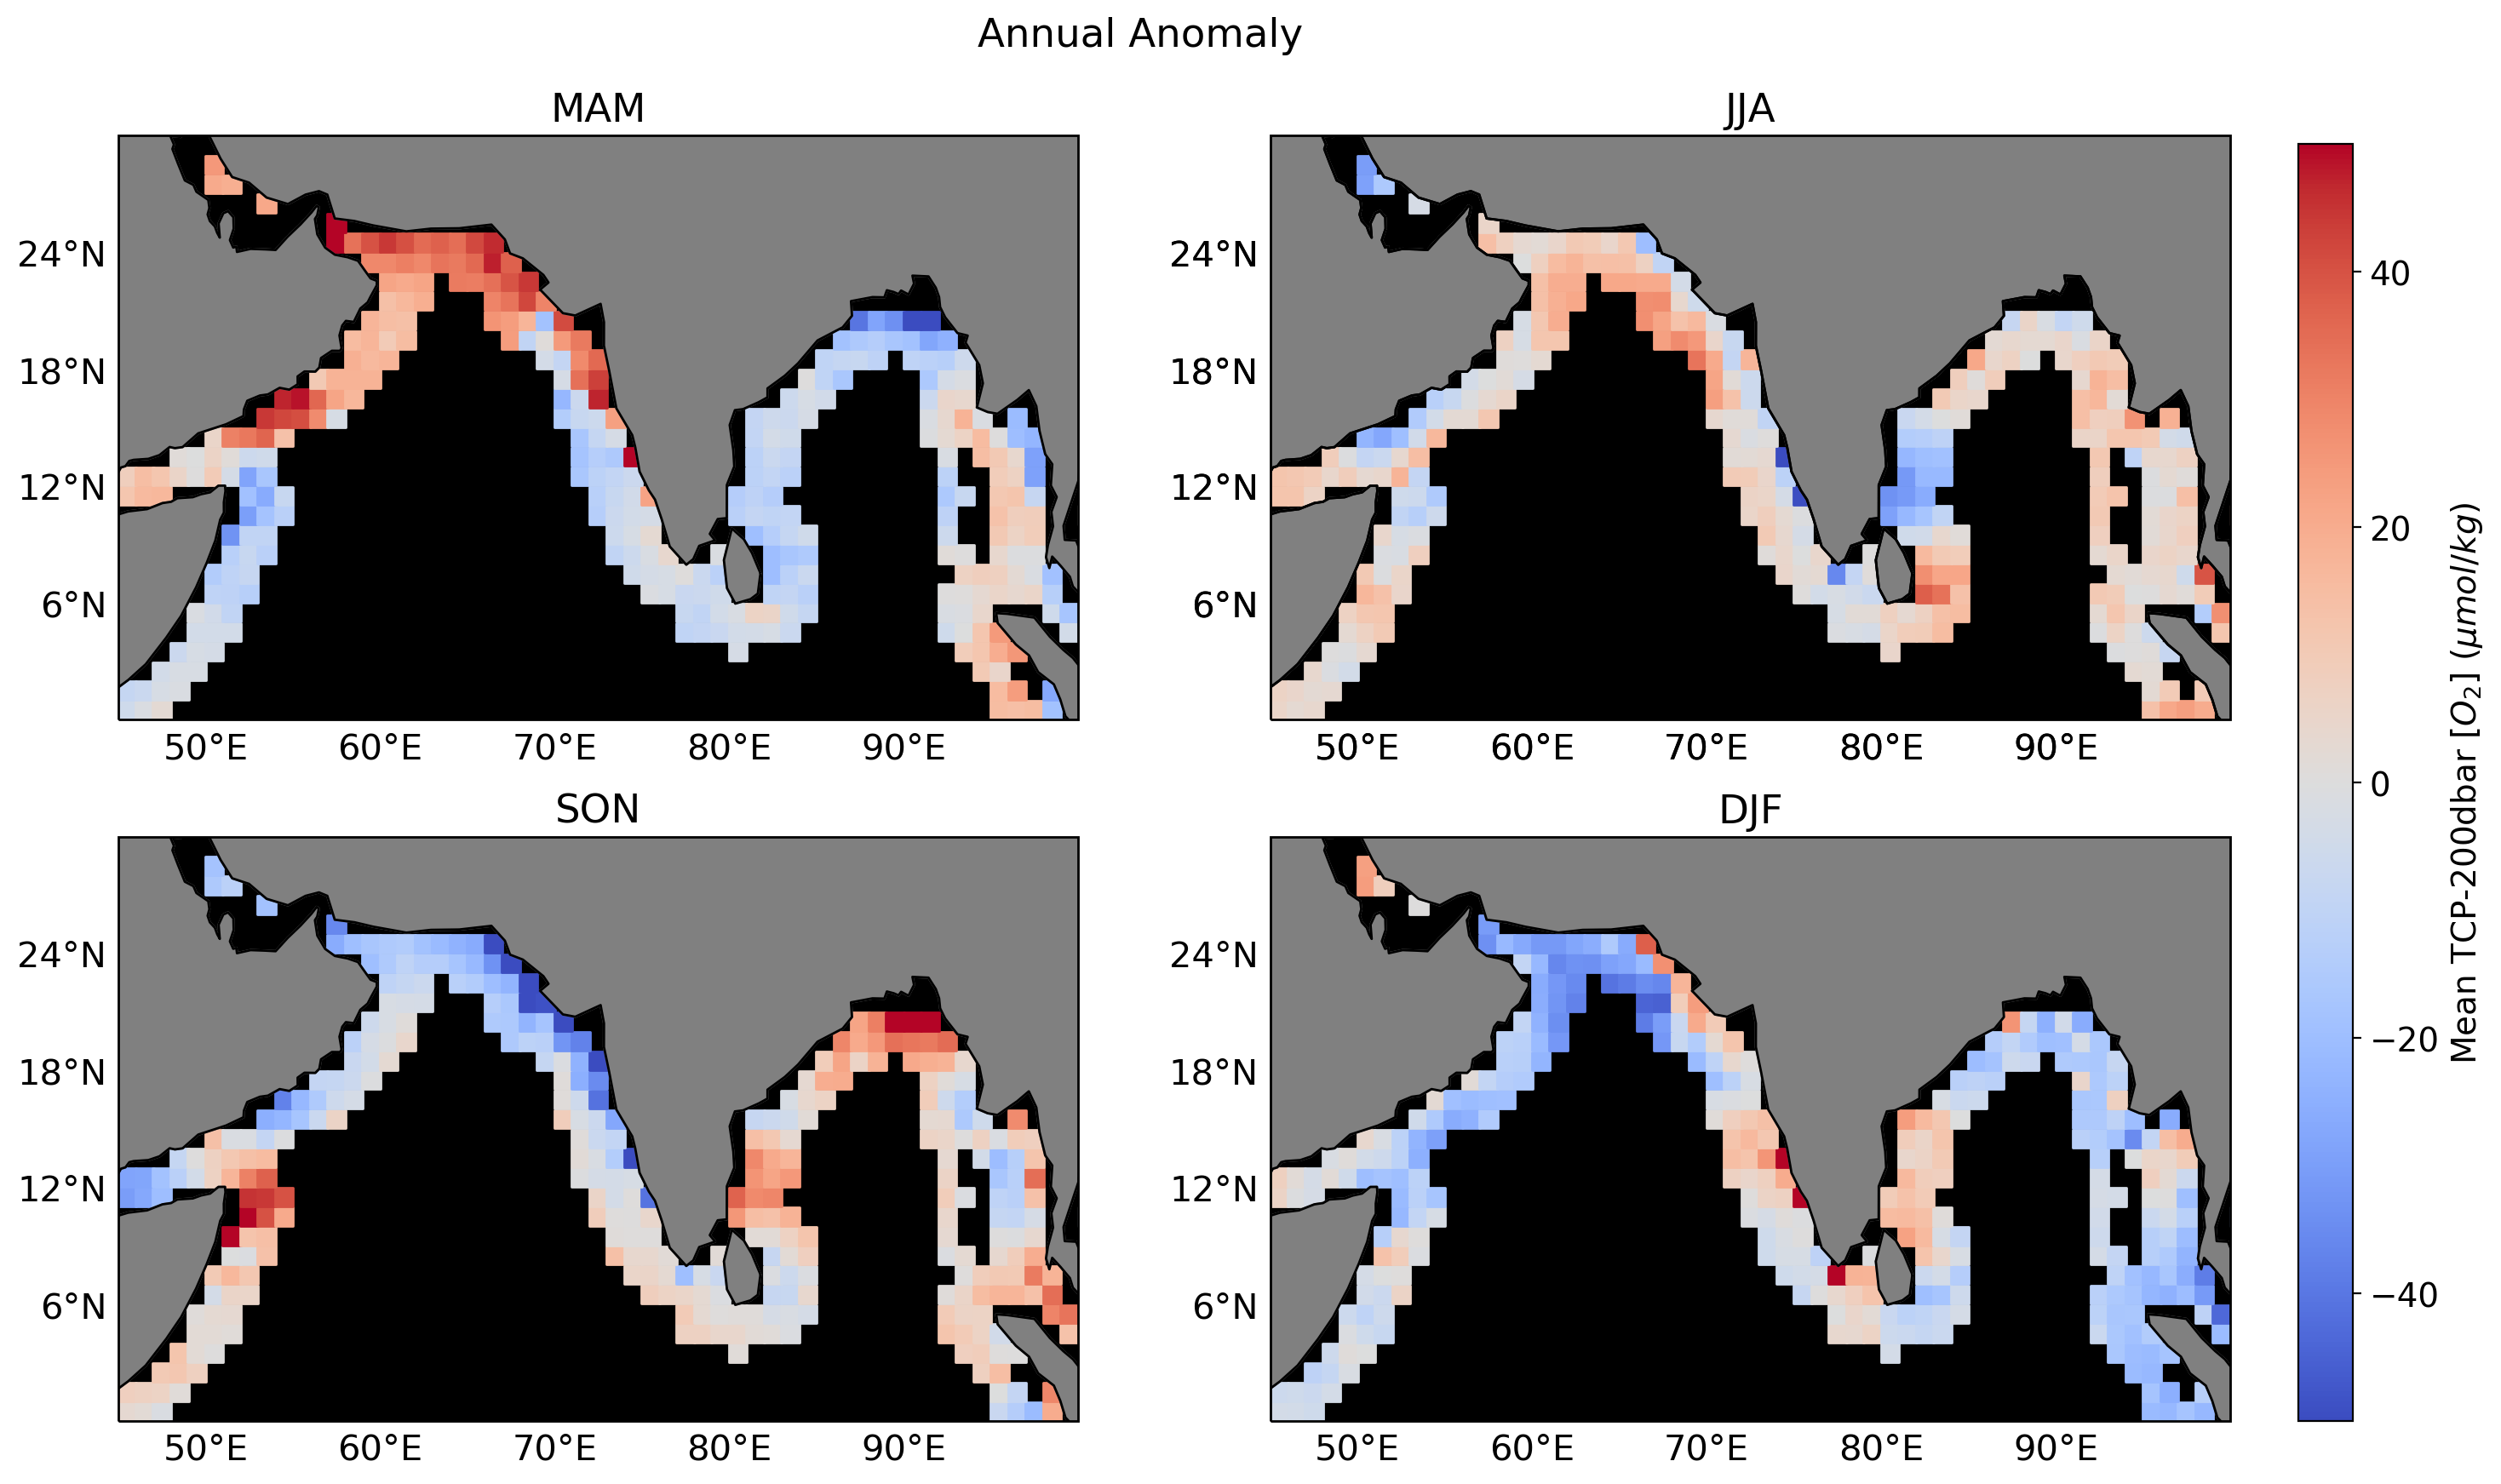

In [10]:
var = seasonal_anom

coastal = True


fig, axes = plt.subplots(nrows = 2, ncols = 2,figsize=(16,10),dpi=200,subplot_kw={'projection': ccrs.PlateCarree()})
sz = 60
cmin = -50
cmax = 50
cmap = plt.cm.coolwarm
xx,yy = np.meshgrid(ds_CD.lon,ds_CD.lat)
xx = xx.flatten()
yy = yy.flatten()

plt.rcParams.update({'font.size': 14})
season_title = ['MAM','JJA','SON','DJF']

##############################################################
if coastal == True:
    ax = axes[0,0]
    tmp = var[0,:,:]
    tmp = tmp.flatten()
    p = ax.scatter(xx[mask],yy[mask],c = tmp[mask],marker='s',s= sz,
                          cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
    ax.set_title(season_title[0])
    add_land(ax)

    ax = axes[0,1]
    add_land(ax)
    tmp = var[1,:,:]
    tmp = tmp.flatten()
    p = ax.scatter(xx[mask],yy[mask],c = tmp[mask],marker='s',s= sz,
                          cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
    add_land(ax)
    ax.set_title(season_title[1])

    ax = axes[1,0]
    tmp = var[2,:,:]
    tmp = tmp.flatten()
    p = ax.scatter(xx[mask],yy[mask],c = tmp[mask],marker='s', s= sz,
                          cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
    add_land(ax)
    ax.set_title(season_title[2])

    ax = axes[1,1]
    tmp = var[3,:,:]
    tmp = tmp.flatten()
    p = ax.scatter(xx[mask],yy[mask],c = tmp[mask],marker='s',s= sz,
                          cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
    add_land(ax)
    ax.set_title(season_title[3])

else:
    ax = axes[0,0]
    tmp = var[0,:,:]
    tmp = tmp.flatten()
    p = ax.scatter(xx,yy,c = tmp,marker='s',s= sz,
                          cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
    ax.set_title(season_title[0])
    add_land(ax)

    ax = axes[0,1]
    add_land(ax)
    tmp = var[1,:,:]
    tmp = tmp.flatten()
    p = ax.scatter(xx,yy,c = tmp,marker='s',s= sz,
                          cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
    add_land(ax)
    ax.set_title(season_title[1])

    ax = axes[1,0]
    tmp = var[2,:,:]
    tmp = tmp.flatten()
    p = ax.scatter(xx,yy,c = tmp,marker='s',s= sz,
                          cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
    add_land(ax)
    ax.set_title(season_title[2])

    ax = axes[1,1]
    tmp = var[3,:,:]
    tmp = tmp.flatten()
    p = ax.scatter(xx,yy,c = tmp,marker='s',s= sz,
                          cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
    add_land(ax)
    ax.set_title(season_title[3])


cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(p,cax=cbar_ax, pad=0.04)
cbar.set_label('Mean TCP-200dbar [$O_2$] ($\mu mol/ kg$)')
plt.suptitle('Annual Anomaly', y=0.95)


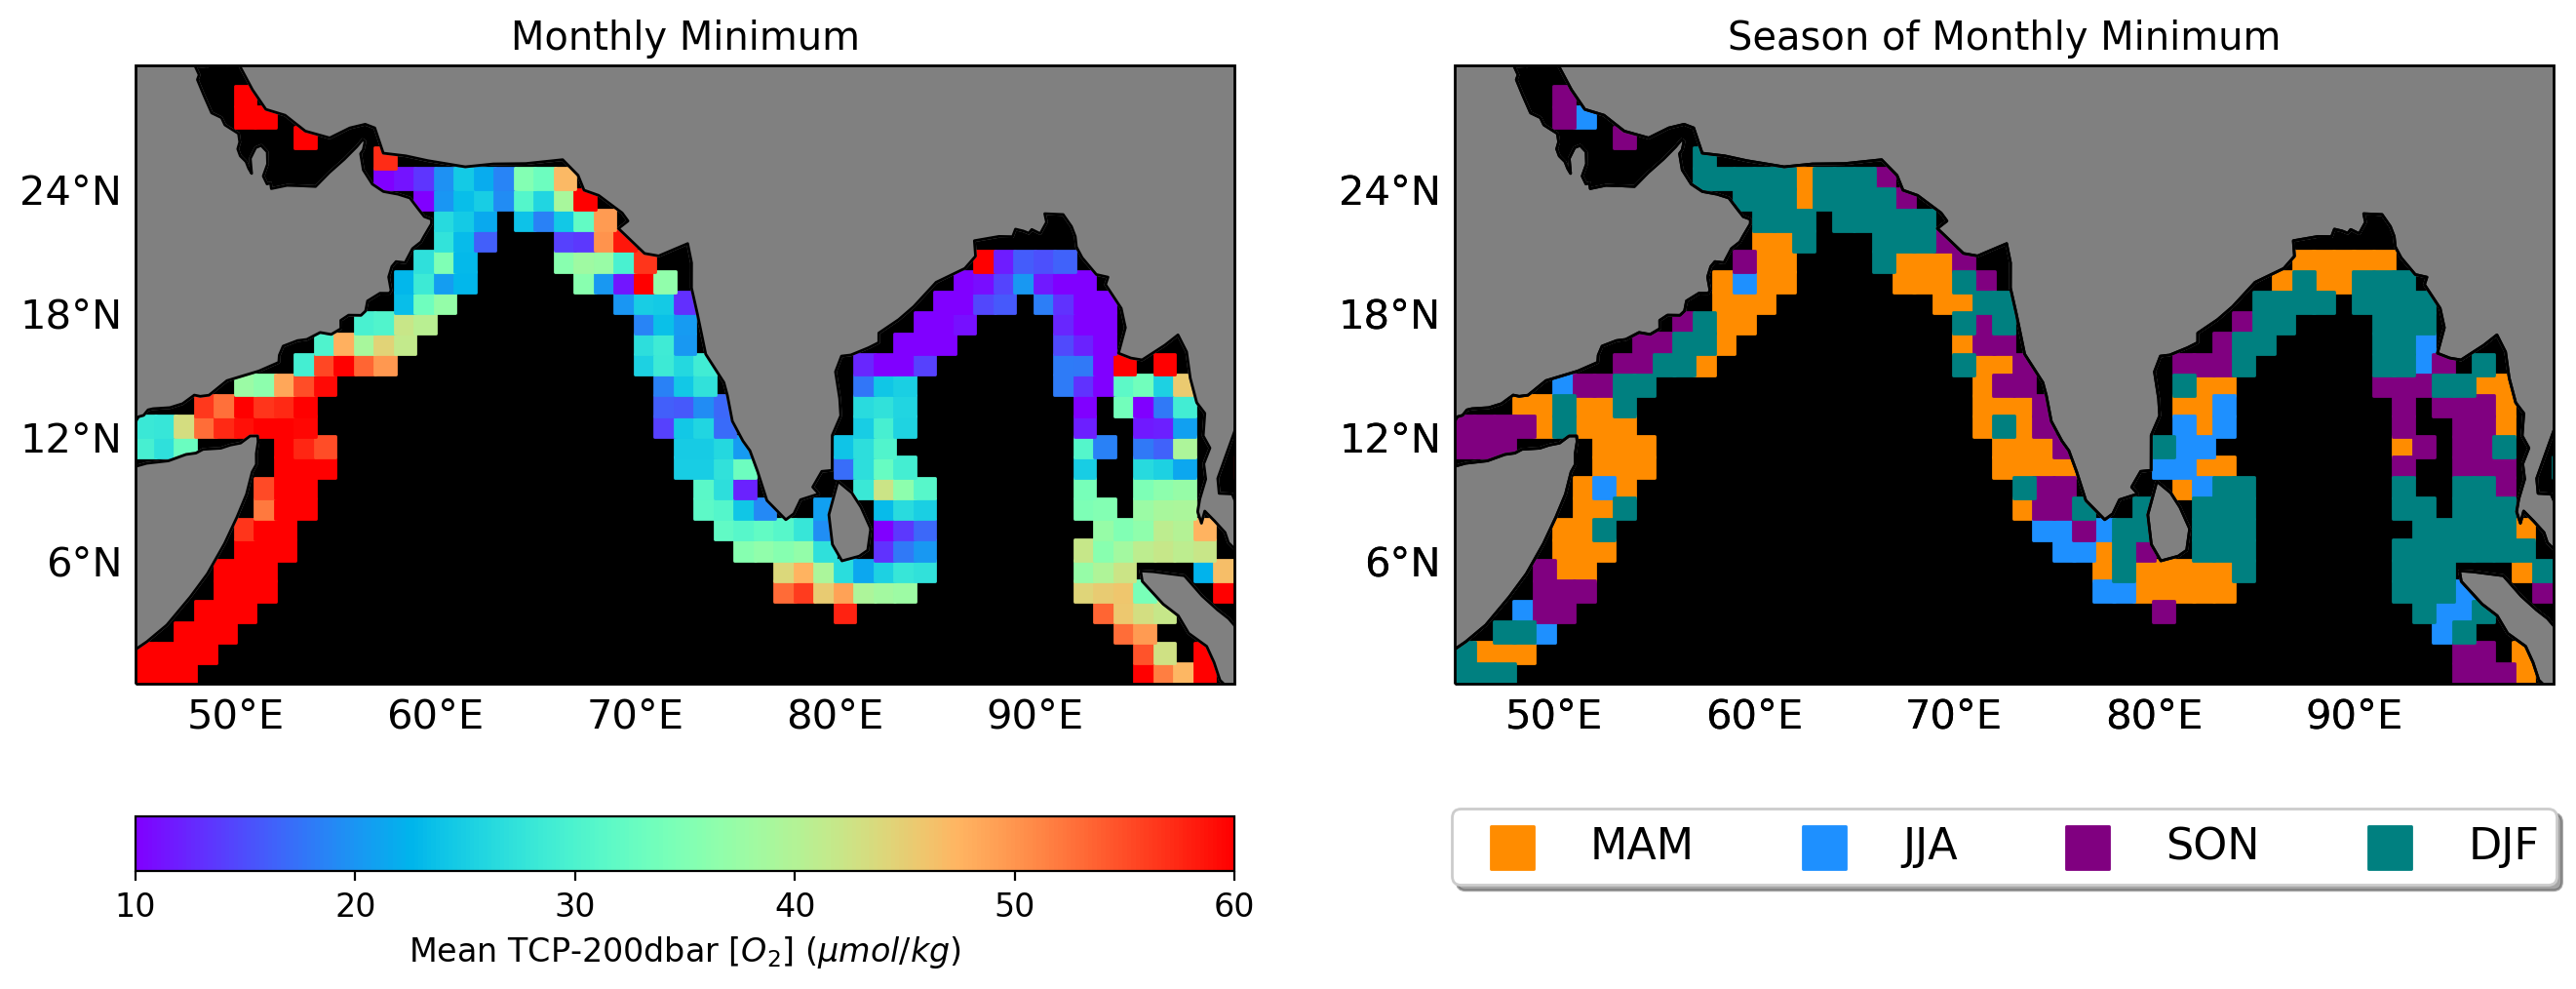

In [16]:
var1 = min_mean
var2 = min_mean_seas

coastal = True


fig, axes = plt.subplots(nrows = 1, ncols = 2,figsize=(16,6),dpi=200,subplot_kw={'projection': ccrs.PlateCarree()})
sz = 60

cmin1 = 10
cmax1 = 60

cmin2 = 1
cmax2 = 4

cmap1 = plt.cm.rainbow

# colors = ['royalblue', 'cyan','yellow', 'orange']
colors = ['darkorange','dodgerblue','purple', 'teal']

xx,yy = np.meshgrid(ds_CD.lon,ds_CD.lat)
xx = xx.flatten()
yy = yy.flatten()

plt.rcParams.update({'legend.fontsize': 16,
                     'legend.handlelength': 2,
                     "legend.markerscale":2,
                     'font.size': 12})

title = ['Monthly Minimum','Season of Monthly Minimum']
season_title = ['MAM','JJA','SON','DJF']
##############################################################
if coastal == True:
    ax = axes[0]
    tmp = var1.flatten()
    p = ax.scatter(xx[mask],yy[mask],c = tmp[mask],marker='s',s= sz,
                          cmap=cmap1,vmin=cmin1,vmax=cmax1,transform=ccrs.PlateCarree())
    ax.set_title(title[0])
    add_land(ax)
    cbar = plt.colorbar(p, ax = ax,orientation='horizontal')
    cbar.set_label('Mean TCP-200dbar [$O_2$] ($\mu mol/ kg$)')

    ax = axes[1]
    add_land(ax)
    tmp = var2.flatten()
    tmp = tmp[mask]
    xx = xx[mask]
    yy = yy[mask]
    season = np.arange(1,5)
    for ss in range(4):
        ind = tmp == (season[ss])
        
        p = ax.scatter(xx[ind],yy[ind],c = colors[ss],label = season_title[ss],marker='s',s= sz,
                          vmin=cmin2,vmax=cmax2,transform=ccrs.PlateCarree())
    add_land(ax)
    ax.set_title(title[1])
    # get first axes height
    
    box0 = axes[0].get_position()
    box = ax.get_position()
    ax.set_position([box.x0, box0.y0, box0.width, box0.height])
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -.36),
          ncol=4, fancybox=True, shadow=True)

else:
    ax = axes[0]
    tmp = var1.flatten()
    p = ax.scatter(xx,yy,c = tmp,marker='s',s= sz,
                          cmap=cmap1,vmin=cmin1,vmax=cmax1,transform=ccrs.PlateCarree())
    ax.set_title(title[0])
    add_land(ax)
    cbar = plt.colorbar(p, ax = ax,orientation='horizontal')
    cbar.set_label('Mean TCP-200dbar [$O_2$] ($\mu mol/ kg$)')

    ax = axes[1]
    add_land(ax)
    tmp = var2.flatten()
    season = np.arange(1,5)
    for ss in range(4):
        ind = tmp == (season[ss])
        p = ax.scatter(xx[ind],yy[ind],c = colors[ss],label = season_title[ss],marker='s',s= sz,
                          vmin=cmin2,vmax=cmax2,transform=ccrs.PlateCarree())
    add_land(ax)
    ax.set_title(title[1])
    # get first axes height
    
    box0 = axes[0].get_position()
    box = ax.get_position()
    ax.set_position([box.x0, box0.y0, box0.width, box0.height])
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -.36),
          ncol=4, fancybox=True, shadow=True)


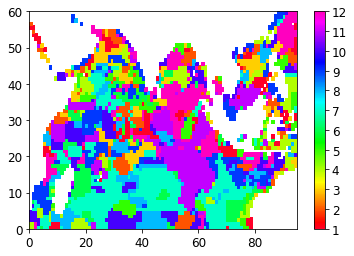

In [25]:

cmap = plt.cm.gist_rainbow
plt.pcolormesh(min_mean_mon,cmap=cmap)
cbar = plt.colorbar()
cbar.set_ticks(np.arange(1,13))
cbar.set_ticklabels(np.arange(1,13))


In [26]:
np.unique(min_mean_mon)[0:12]

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])

In [27]:
# end

In [29]:
var = ds_CD.doxy_TCP_200_mean

# get seasonal anomaly
# 1 = MAM, 2 = JJA, 3 = SON, 4 = DJF
seasonal_anom = np.full([2,len(ds_CD.lat),len(ds_CD.lon)],np.nan)
seasonal_mean = np.full([2,len(ds_CD.lat),len(ds_CD.lon)],np.nan)
for ss in range(2):
    if ss == 0:
        ind = [0,1,2,3,4,5,6]
        seasonal_mean[ss,:,:] = np.nanmean(var[ind,:,:],0)
        seasonal_anom[ss,:,:] = np.nanmean(var[ind,:,:],0) - np.nanmean(var,0)
        
    elif ss == 1:
        ind = [7,8,9,10,11]
        seasonal_mean[ss,:,:] = np.nanmean(var[ind,:,:],0)
        seasonal_anom[ss,:,:] = np.nanmean(var[ind,:,:],0) - np.nanmean(var,0)

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


Text(0.5, 0.98, 'Annual Anomaly')

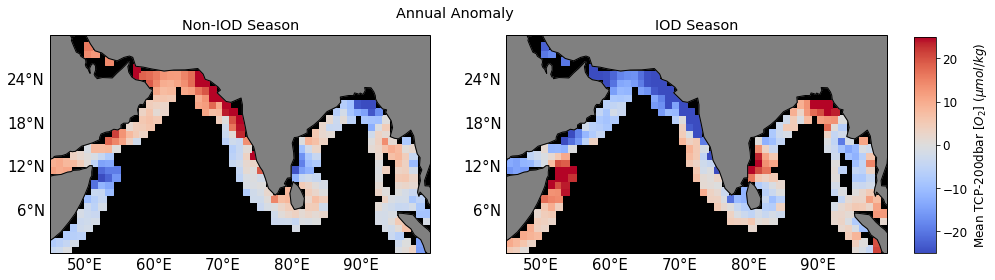

In [33]:
xx,yy = np.meshgrid(ds_CD.lon,ds_CD.lat)
xx = xx.flatten()
yy = yy.flatten()

plt.rcParams.update({'legend.fontsize': 16,
                     'legend.handlelength': 2,
                     "legend.markerscale":2,
                     'font.size': 12})
cmin = -25
cmax = 25
cmap = plt.cm.coolwarm
fig,(ax1,ax2) = plt.subplots(1,2,figsize = (15,4),subplot_kw={'projection': ccrs.PlateCarree()})


###############################################
tmp = seasonal_anom[0,:,:]
tmp = tmp.flatten()
tmp = tmp[mask]
xx = xx[mask]
yy = yy[mask]

p = ax1.scatter(xx,yy,c = tmp,marker='s',s= sz,
                          cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
add_land(ax1)
ax1.set_title('Non-IOD Season')

tmp = seasonal_anom[1,:,:]
tmp = tmp.flatten()
tmp = tmp[mask]

p = ax2.scatter(xx,yy,c = tmp,marker='s',s= sz,
                          cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
add_land(ax2)
ax2.set_title('IOD Season')

cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(p,cax=cbar_ax, pad=0.04)
cbar.set_label('Mean TCP-200dbar [$O_2$] ($\mu mol/ kg$)')
plt.suptitle('Annual Anomaly', y=0.98)

Text(0.5, 0.98, 'Seasonal Mean')

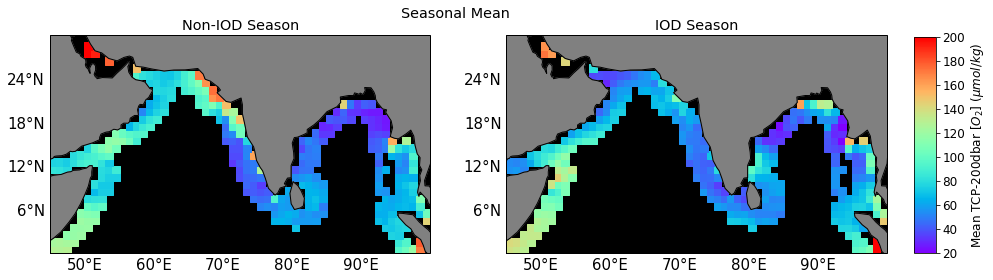

In [35]:
xx,yy = np.meshgrid(ds_CD.lon,ds_CD.lat)
xx = xx.flatten()
yy = yy.flatten()

plt.rcParams.update({'legend.fontsize': 16,
                     'legend.handlelength': 2,
                     "legend.markerscale":2,
                     'font.size': 12})
cmin = 20
cmax = 200
cmap = plt.cm.rainbow
fig,(ax1,ax2) = plt.subplots(1,2,figsize = (15,4),subplot_kw={'projection': ccrs.PlateCarree()})


###############################################
tmp = seasonal_mean[0,:,:]
tmp = tmp.flatten()
tmp = tmp[mask]
xx = xx[mask]
yy = yy[mask]

p = ax1.scatter(xx,yy,c = tmp,marker='s',s= sz,
                          cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
add_land(ax1)
ax1.set_title('Non-IOD Season')

tmp = seasonal_mean[1,:,:]
tmp = tmp.flatten()
tmp = tmp[mask]

p = ax2.scatter(xx,yy,c = tmp,marker='s',s= sz,
                          cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
add_land(ax2)
ax2.set_title('IOD Season')

cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(p,cax=cbar_ax, pad=0.04)
cbar.set_label('Mean TCP-200dbar [$O_2$] ($\mu mol/ kg$)')
plt.suptitle('Seasonal Mean', y=0.98)

In [ ]:
cmin = 0
cmax = 200
cmap = plt.cm.coolwarm
fig,(ax1,ax2) = plt.subplots(1,2,figsize = (15,4))
p = ax1.pcolormesh(seasonal_anom[0,:,:]+ ann_mean_doxy,cmap = cmap, vmin = cmin, vmax = cmax)
plt.colorbar(p, ax = ax1)
p = ax2.pcolormesh(seasonal_anom[1,:,:]+ ann_mean_doxy,cmap = cmap,vmin = cmin, vmax = cmax)
plt.colorbar(p, ax = ax2)